In [1]:
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel(40)  # suppress deprecation messages
tf.compat.v1.disable_v2_behavior()  # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import os
from alibi.explainers import CEM

In [2]:
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())  # False

TF version:  2.12.0
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)
(10000, 28, 28)


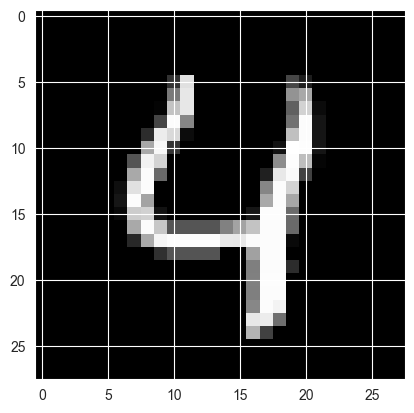

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print(x_test.shape)
plt.gray()
plt.imshow(x_test[4])
plt.show()

In [4]:
# Normalize and reshape the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(60000,784,)
x_test = x_test.reshape(10000,784,)
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

x_train shape: (60000, 784) x_test shape: (10000, 784)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [2]:
# Define CNN model
def cnn_model():
    # Input layer for flattened image
    x_in = Input(shape=(784,))
    # Reshape layer to convert input to 28x28x1 image
    x = Reshape((28, 28, 1))(x_in)
    
    # Convolutional layers
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)  # Pooling layer
    x = Dropout(0.3)(x)  # Dropout layer

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    # Create model
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

NameError: name 'X_flat' is not defined

In [6]:

# Create and train CNN model
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1)
# Save the trained model
cnn.save('mnist_cnn.h5', save_format='h5')
# Evaluate the model performance on test dataset
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                             

D:\Anaconda\envs\course02502\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy:  0.9874


In [7]:
def ae_model():
    # Input accepts a flat vector of size 784
    x_in = Input(shape=(784,))
    # Reshape flat vector to (28, 28, 1) for convolutional layers
    x = Reshape((28, 28, 1))(x_in)
    
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)  # Activated relu for stability
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(1, (3, 3), activation=None, padding='same')(x)  # Using sigmoid for final layer if images are normalized [0,1]
    x = Flatten()(x)  # Flatten the output to match the input shape
    
    # Create the autoencoder model
    autoencoder = Model(inputs=x_in, outputs=x)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

x_train_flat = x_train.reshape(-1, 784)  
x_test_flat = x_test.reshape(-1, 784)   

ae = ae_model()
ae.summary()

# Train the model
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)

# Save the trained model
ae.save('mnist_ae.h5', save_format='h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 1)         145       
                                                           

D:\Anaconda\envs\course02502\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


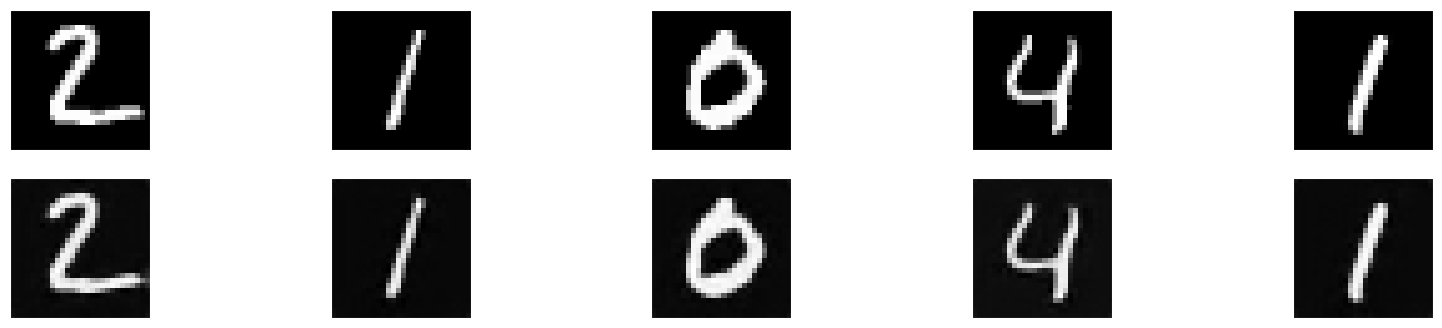

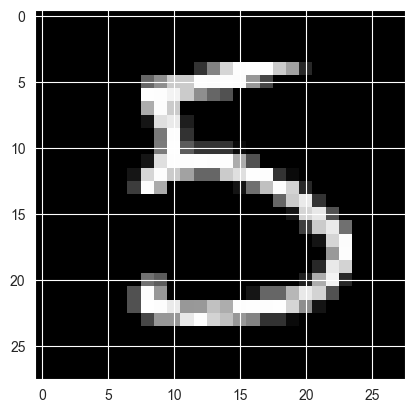

In [8]:
ae = load_model('mnist_ae.h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

idx = 15
X = x_test_flat[idx].reshape(1, 784)

plt.imshow(X.reshape(28, 28));

In [9]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.99713695)

In [119]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [ ]:
desired_prediction = 5
count = 0
max_tries = 1000
all_results = []  

cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

for i in range(max_tries):
    explanation = cem.explain(X)
    print(f'Trial {i + 1}/{max_tries}: Prediction - {explanation.PN_pred}')  # 显示每次尝试的结果
    if explanation.PN_pred == desired_prediction:
        all_results.append(explanation.PN)
        count += 1
        print(f'Found {count}: Pertinent negative prediction matches 5.')
        plt.imshow(explanation.PN.reshape(28, 28))
        plt.show()
    if count == 100:
        print("Collected 100 matching PNs.")
        break

# Optionally, handle if no results found after max_tries
if not all_results:
    print("No pertinent negatives with prediction 5 found after maximum tries.")
elif len(all_results) < 100:
    print(f"Only found {len(all_results)} results matching prediction 5 after {max_tries} trials.")

# The array `all_results` now contains up to 100 PN instances that you can access later.

Pertinent negative prediction: 3


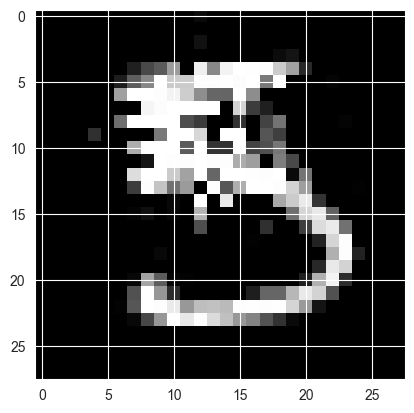

In [120]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN.reshape(28, 28));

Pertinent positive prediction: 5


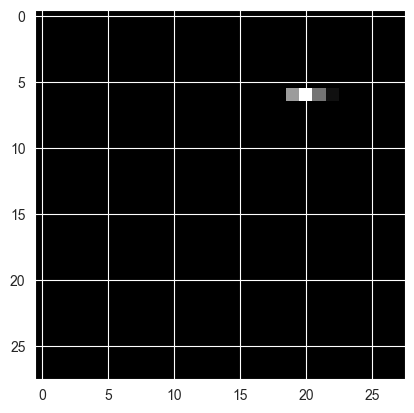

In [125]:
mode = 'PP'
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28));

In [146]:
# os.remove('mnist_cnn.h5')
# os.remove('mnist_ae.h5')

## Counter Factual Image R

126


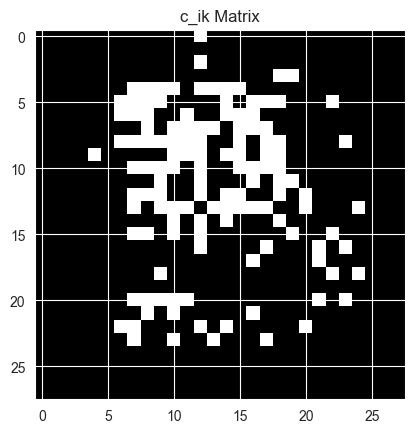

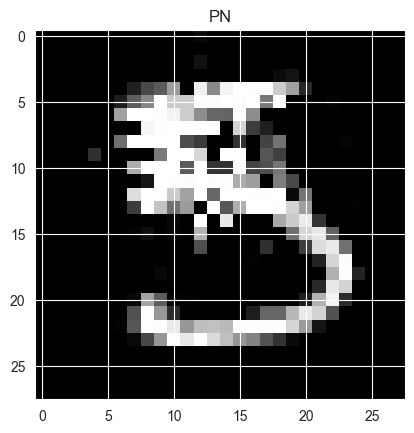

In [121]:
R = explanation.PN.reshape(28,28).copy()
c_ik = np.where(X.reshape(28,28) != explanation.PN.reshape(28,28), 1, 0)
changed_pixel = np.sum(c_ik)
print(changed_pixel)
plt.imshow(c_ik.reshape(28,28),cmap='gray')
plt.title('c_ik Matrix')
plt.show()
plt.imshow(R)
plt.title('PN')
plt.show()

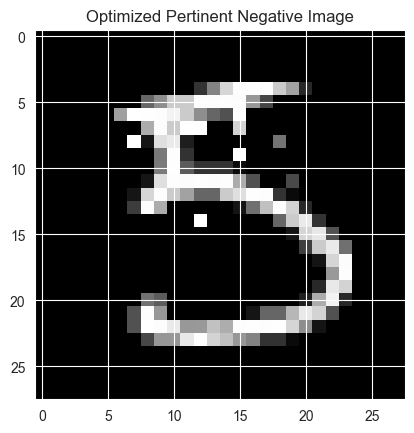

In [122]:
PN_optimized1 = R.copy()
c_ik_cp = c_ik.copy()
target_label = explanation.PN_pred.copy()  # Assuming this is correctly obtained from somewhere
X_reshaped = X.reshape(28,28)  # Assuming X was initially (784,)

for i in range(28):
    for j in range(28):
        # Only try to restore pixel where c_ik is 1
        if c_ik_cp[i, j] == 1:
            PN_temp = PN_optimized1.copy()
            PN_temp[i, j] = X_reshaped[i, j]
            # Ensure correct reshaping for model prediction
            prediction_temp = cnn.predict(PN_temp.reshape(1, 784))
            # Check if the predicted class matches the target label
            if prediction_temp.argmax() == target_label:
                PN_optimized1[i, j] = X_reshaped[i, j]
                c_ik_cp[i, j] = 0  # Mark this pixel as no longer changeable

plt.imshow(PN_optimized1.reshape(28, 28), cmap='gray')
plt.title('Optimized Pertinent Negative Image')
plt.show()

In [123]:
target_label

3

11


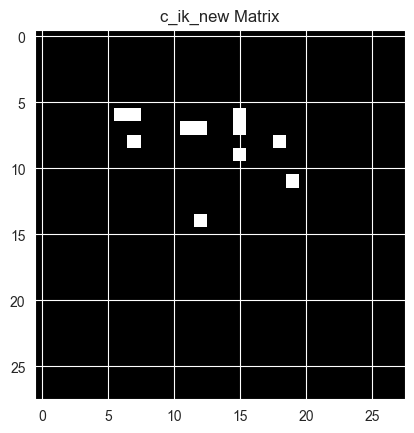

3


In [124]:
c_ik_cp = np.where(X.reshape(28,28) != PN_optimized1.reshape(28,28), 1, 0)
changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())

## Compute Matching

In [125]:
import ot
X_cp = X.copy()
R_cp = R.copy()
c_ik_cp = c_ik.copy()
target_label = explanation.PN_pred.copy()

def compute_ot_distance_matrix(x, r):
    n = x.shape[0]
    m = r.shape[0]
    distance_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            distance_matrix[i, j] = np.linalg.norm(x[i] - r[j])
    return distance_matrix

def compute_joint_distribution(x, r, reg=0.1):
    distance_matrix = compute_ot_distance_matrix(x, r)
    p = ot.sinkhorn(np.ones(x.shape[0]) / x.shape[0], np.ones(r.shape[0]) / r.shape[0], distance_matrix, reg)
    return p

x = X_cp.reshape(-1,1)
r = R_cp.reshape(-1,1)
p = compute_joint_distribution(x,r)
p = p / np.sum(p)
print("Joint Distribution matrix p:\n",p)
print(p.shape)

Joint Distribution matrix p:
 [[1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]
 [1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]
 [1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]
 ...
 [1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]
 [1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]
 [1.93212691e-06 1.93212691e-06 1.93212691e-06 ... 1.93212691e-06
  1.93212691e-06 1.93212691e-06]]
(784, 784)


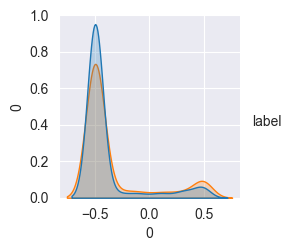

In [126]:
import pandas as pd
import seaborn as sns
X_cp_df = pd.DataFrame(X_cp.reshape(-1,1))
R_cp_df = pd.DataFrame(R_cp.reshape(-1,1))

X_cp_df['label'] = 'X_cp'
R_cp_df['label'] = 'R_cp'

combined_df = pd.concat([X_cp_df, R_cp_df],ignore_index=True)
sns.pairplot(combined_df, hue='label', plot_kws={'alpha':0.5}, diag_kind='kde')
plt.show()

## Using the difference matrix the reduce the pixel changed

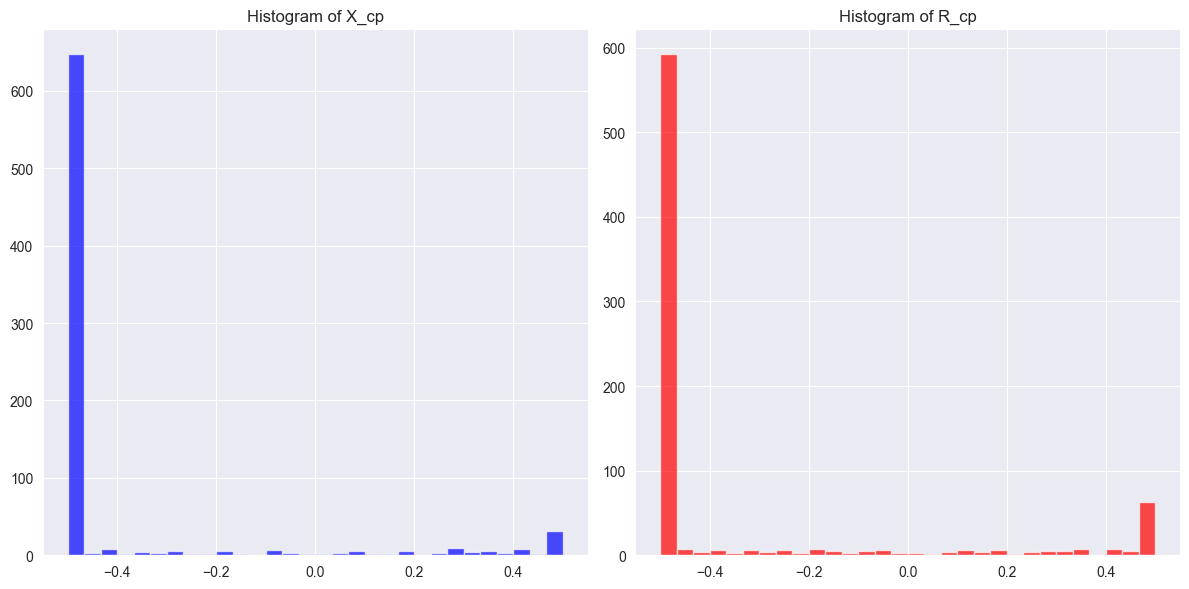

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(X_cp.flatten(), bins=30, alpha=0.7, color='blue')
ax[0].set_title('Histogram of X_cp')
ax[1].hist(R_cp.flatten(), bins=30, alpha=0.7, color='red')
ax[1].set_title('Histogram of R_cp')

plt.tight_layout()
plt.show()


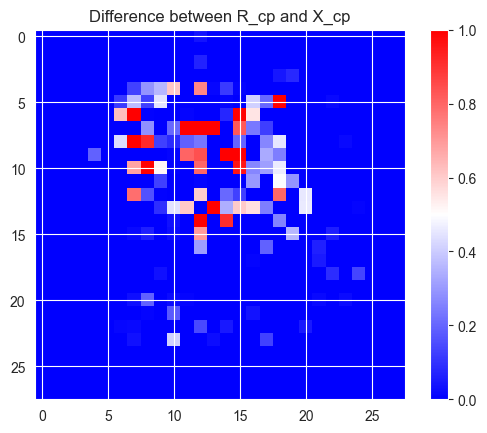

In [128]:
Diff = R_cp - X_cp.reshape(28,28)
plt.imshow(Diff, cmap='bwr') 
plt.colorbar()
plt.title('Difference between R_cp and X_cp')
plt.show()

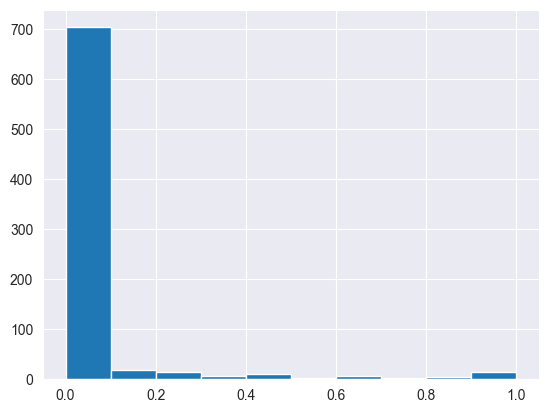

In [129]:
plt.hist(Diff.ravel())
plt.show()

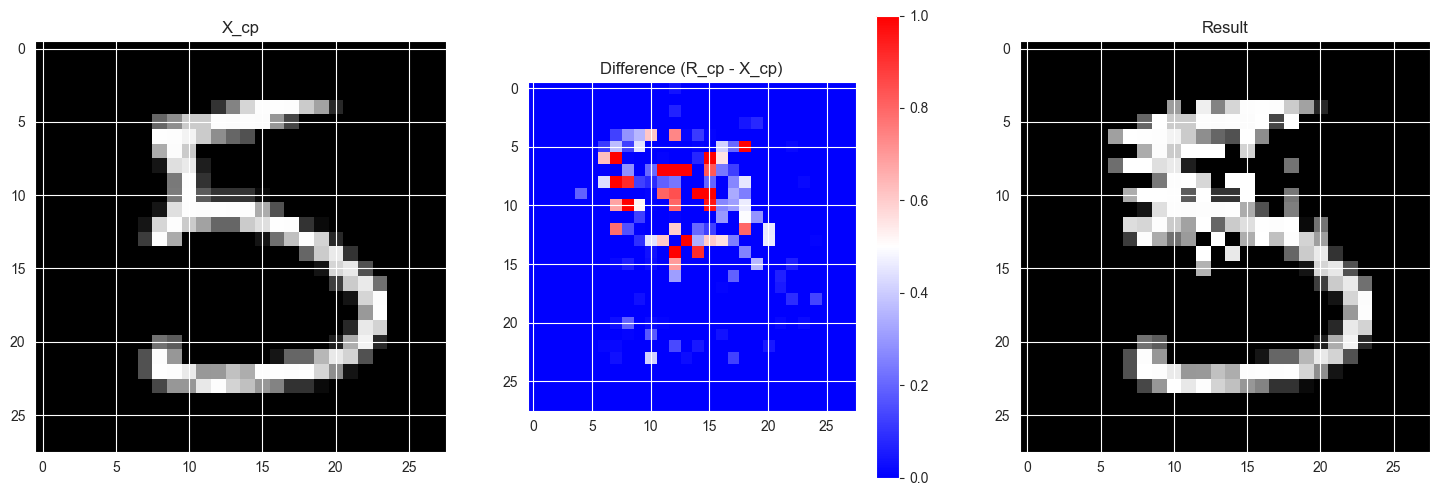

In [130]:
Result = np.where(Diff < 0.37, X_cp.reshape(28,28), R_cp)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(X_cp.reshape(28,28), cmap='gray')
axes[0].set_title('X_cp')

im = axes[1].imshow(Diff, cmap='bwr')
fig.colorbar(im, ax=axes[1])
axes[1].set_title('Difference (R_cp - X_cp)')

axes[2].imshow(Result, cmap='gray')
axes[2].set_title('Result')

plt.show()

In [131]:
cnn.predict(Result.reshape(1,784)).argmax()

3

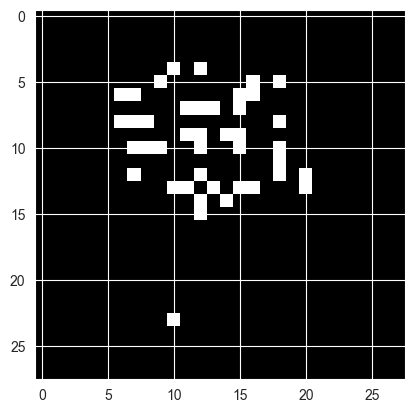

42


In [132]:
c_ik_result = np.where(X.reshape(28,28) != Result.reshape(28,28), 1, 0)
plt.imshow(c_ik_result)
plt.show()
print(np.sum(c_ik_result))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


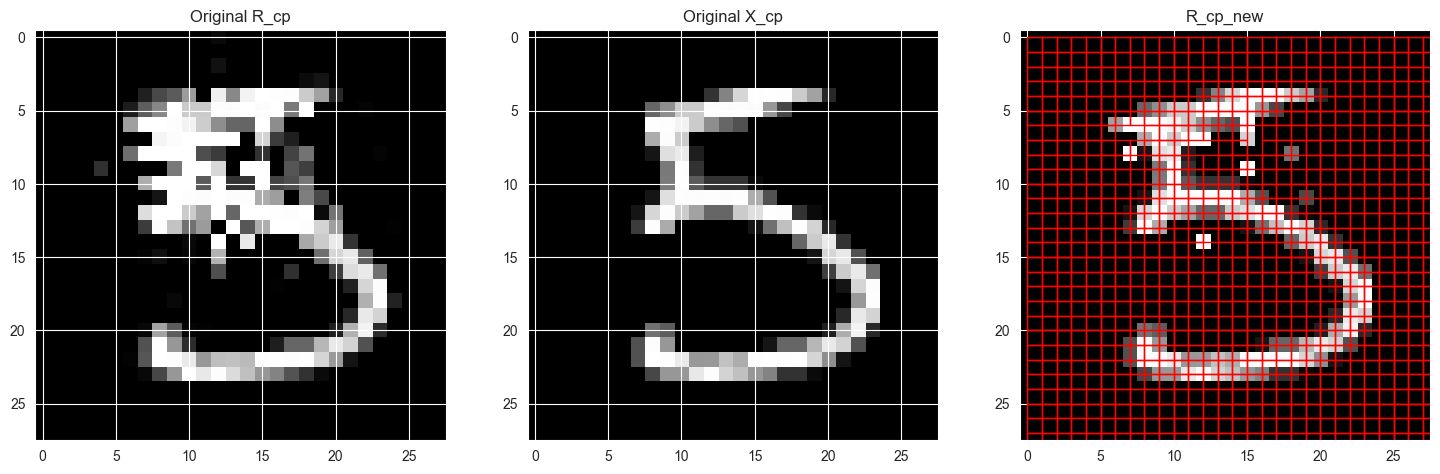

In [133]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def update_image_block(image, source, target, block_size, start_row, start_col):
    image[start_row:start_row + block_size, start_col:start_col + block_size] = source[start_row:start_row + block_size, start_col:start_col + block_size]
    return image

def add_highlight(rectangles, start_row, start_col, block_size):
    rect = patches.Rectangle((start_col, start_row), block_size, block_size, linewidth=1, edgecolor='r', facecolor='none')
    rectangles.append(rect)

block_size = 1
R_cp_new = R_cp.copy()
highlights = []

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 遍历每个块
for i in range(0, 28, block_size):
    for j in range(0, 28, block_size):
        temp_image = R_cp_new.copy()
        temp_image = update_image_block(temp_image, X_cp.reshape(28, 28), R_cp, block_size, i, j)
        
        prediction = cnn.predict(temp_image.reshape(1, 784)).argmax()
        print(prediction)

        if prediction != target_label:
            R_cp_new = update_image_block(R_cp_new, R_cp.reshape(28, 28), X_cp, block_size, i, j)
        else:
            R_cp_new = update_image_block(R_cp_new, X_cp.reshape(28, 28), R_cp, block_size, i, j)
            add_highlight(highlights, i, j, block_size)

# 显示原始和更新后的图片
axes[0].imshow(R_cp, cmap='gray')
axes[0].set_title('Original R_cp')

axes[1].imshow(X_cp.reshape(28, 28), cmap='gray')
axes[1].set_title('Original X_cp')

axes[2].imshow(R_cp_new, cmap='gray')
axes[2].set_title('R_cp_new')

for rect in highlights:
    axes[2].add_patch(rect)

plt.show()


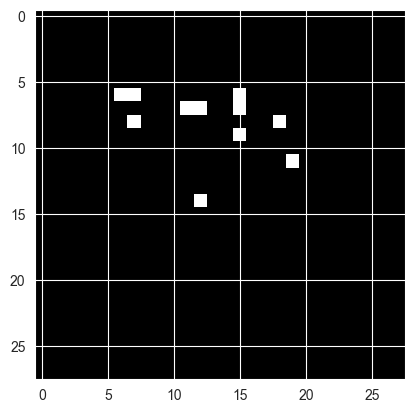

11


3

In [134]:
c_ik_new = np.where(X.reshape(28,28) != R_cp_new.reshape(28,28), 1, 0)
plt.imshow(c_ik_new)
plt.show()
print(np.sum(c_ik_new))
cnn.predict(R_cp_new.reshape(1,784)).argmax()

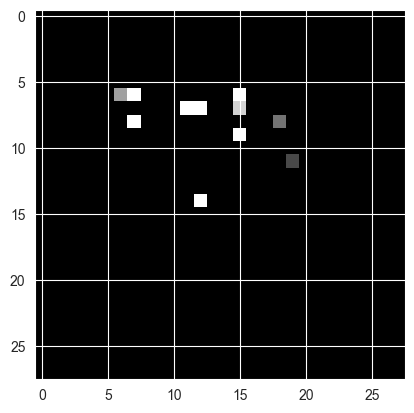

In [135]:
plt.imshow(R_cp_new.reshape(28,28)-X_cp.reshape(28,28))
plt.show()

## Compute Shapely

In [136]:
import shap
R_cp_flat = R_cp.reshape(1, 784)
X_cp_flat = X_cp.reshape(1, 784)

# Calculate marginal probabilities
p_mar = np.sum(p, axis=0)

# Create a SHAP explainer based on the sampled data
explainer_temp = shap.KernelExplainer(
    cnn.predict, X_cp_flat
)

# Calculate SHAP values for R_cp_flat
shap_sample_size = 'auto'
shap_values = explainer_temp.shap_values(R_cp_flat, nsamples=shap_sample_size)

print(shap_values)

  0%|          | 0/1 [00:00<?, ?it/s]

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


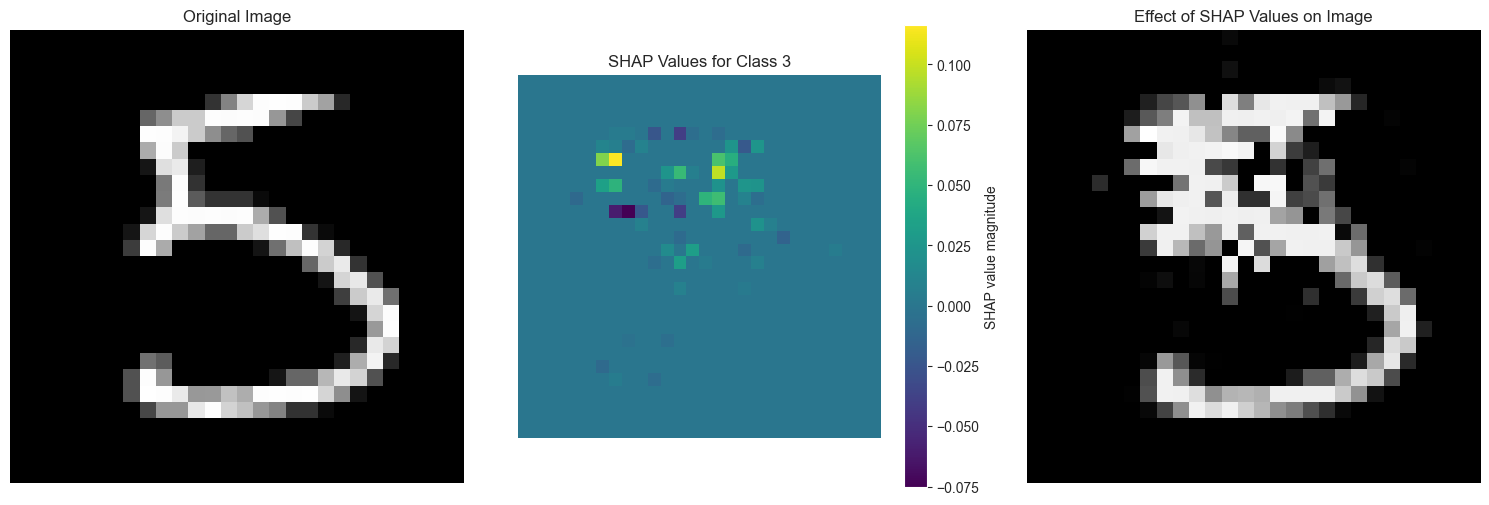

In [137]:
predicted_class = target_label

shap_values_class = shap_values[0, :, predicted_class].reshape(28, 28)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(X_cp_flat.reshape(28, 28), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

shap_display = axes[1].imshow(shap_values_class, cmap='viridis')
axes[1].set_title(f'SHAP Values for Class {predicted_class}')
axes[1].axis('off')

cbar = fig.colorbar(shap_display, ax=axes[1], orientation='vertical')
cbar.set_label('SHAP value magnitude')

effect_display = axes[2].imshow(R_cp_flat.reshape(28, 28) + shap_values_class * 0.5, cmap='gray')
axes[2].set_title('Effect of SHAP Values on Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()


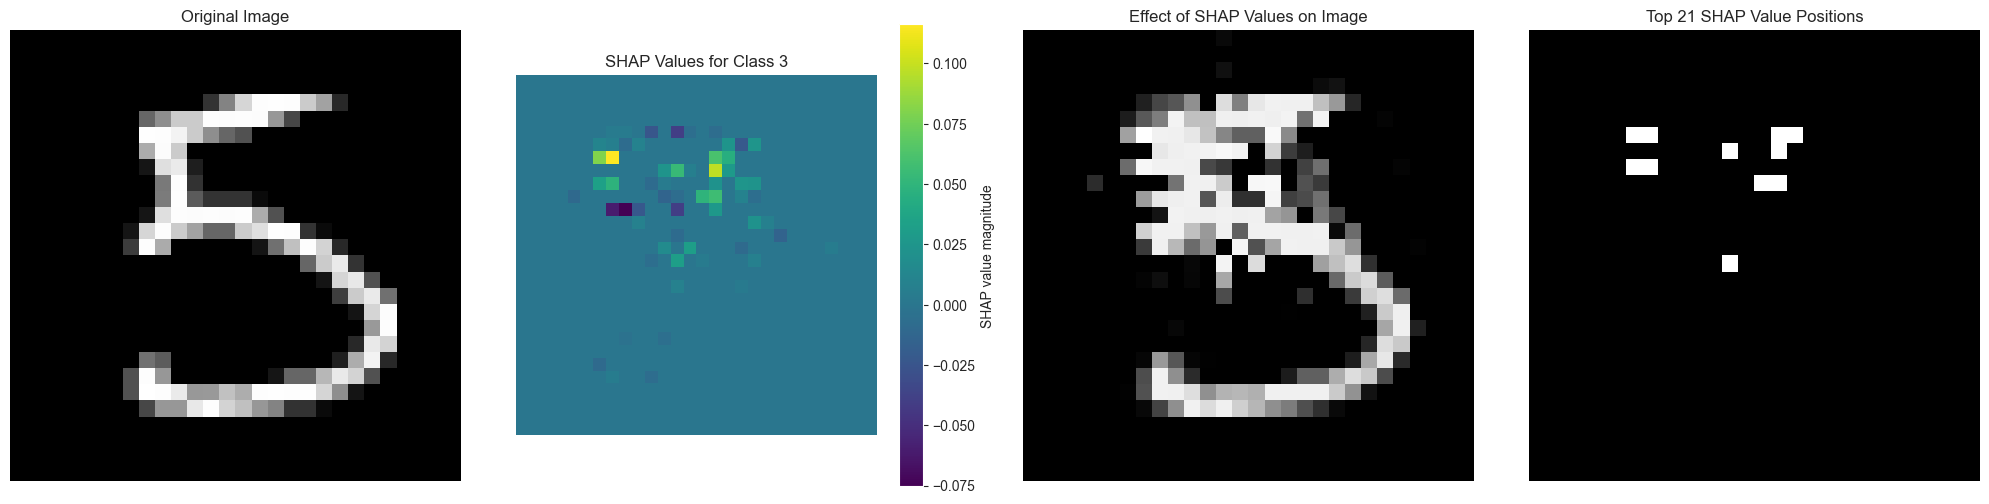

In [147]:
import matplotlib.patches as patches

predicted_class = target_label

shap_values_class = shap_values[0, :, predicted_class].reshape(28, 28)

flat_shap_values = shap_values_class.flatten()
top_21_indices = np.argpartition(flat_shap_values, -11)[-11:]
top_21_positions = np.unravel_index(top_21_indices, shap_values_class.shape)

highlight_mask = np.zeros_like(shap_values_class)

highlight_mask[top_21_positions] = 1

# 显示结果
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(X_cp_flat.reshape(28, 28), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

shap_display = axes[1].imshow(shap_values_class, cmap='viridis')
axes[1].set_title(f'SHAP Values for Class {predicted_class}')
axes[1].axis('off')

cbar = fig.colorbar(shap_display, ax=axes[1], orientation='vertical')
cbar.set_label('SHAP value magnitude')

effect_display = axes[2].imshow(R_cp_flat.reshape(28, 28) + shap_values_class * 0.5, cmap='gray')
axes[2].set_title('Effect of SHAP Values on Image')
axes[2].axis('off')

axes[3].imshow(highlight_mask, cmap='gray')
axes[3].set_title('Top 21 SHAP Value Positions')
axes[3].axis('off')

plt.tight_layout()
plt.show()


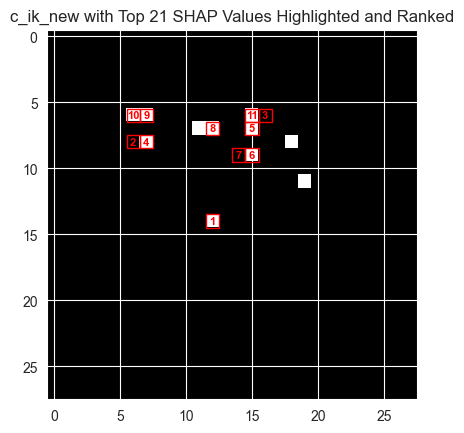

In [148]:
fig, ax = plt.subplots()
ax.imshow(c_ik_new, cmap='gray')
ax.set_title('c_ik_new with Top 21 SHAP Values Highlighted and Ranked')

for i, pos in enumerate(zip(*top_21_positions)):
    rect = patches.Rectangle((pos[1] - 0.5, pos[0] - 0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(pos[1], pos[0], str(i+1), color='red', ha='center', va='center', fontsize=8, weight='bold')

plt.show()

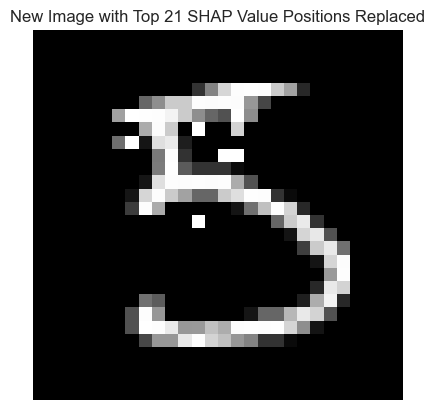

3


In [149]:
top_21_positions_list = list(zip(*top_21_positions))

new_image = X_cp.reshape(1,784).copy()

for pos in top_21_positions_list:
    index = pos[0] * 28 + pos[1]
    new_image[:,index] = R_cp.reshape(1,784)[:,index]

new_image_reshaped = new_image.reshape(28, 28)

plt.imshow(new_image_reshaped, cmap='gray')
plt.title('New Image with Top 21 SHAP Value Positions Replaced')
plt.axis('off')
plt.show()

print(cnn.predict(new_image.reshape(1,784)).argmax())

## Compute Pixel Values

In [38]:
tau_i = np.argmax(p, axis=1)
q_max = R_cp_flat[:,tau_i]

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        

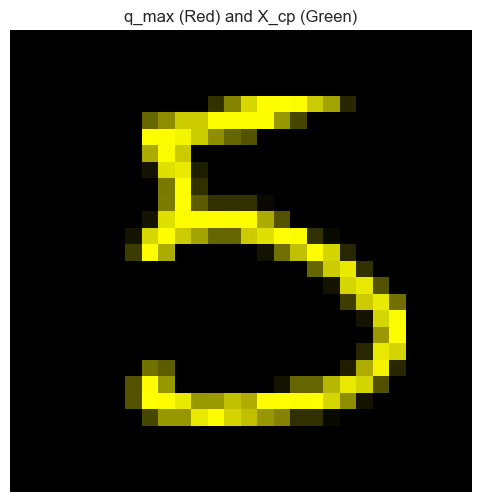

In [47]:
q_max_reshaped = q_max.reshape(28, 28)
X_cp_reshaped = X_cp.reshape(28, 28)

# Plotting the images with different colors
fig, ax = plt.subplots(figsize=(6, 6))

# Create a base image with zeros
base_image = np.zeros((28, 28, 3))

# Normalize the images for better visualization
q_max_norm = (q_max_reshaped - q_max_reshaped.min()) / (q_max_reshaped.max() - q_max_reshaped.min())
X_cp_norm = (X_cp_reshaped - X_cp_reshaped.min()) / (X_cp_reshaped.max() - X_cp_reshaped.min())

# Set q_max values to red channel
base_image[:, :, 0] = q_max_norm

# Set X_cp values to green channel
base_image[:, :, 1] = X_cp_norm

# Display the combined image
ax.imshow(base_image)
ax.set_title('q_max (Red) and X_cp (Green)')
ax.axis('off')

plt.show()

In [41]:
C = 52

# Get the indices of the top C SHAP values
flat_shap_values = shap_values_class.flatten()
top_indices = np.argsort(-flat_shap_values)[:C]

# Create a copy of X_cp_flat to modify
new_image_flat = X_cp_flat.copy()

# Replace the values in new_image_flat at top_indices with corresponding values from q_max
new_image_flat[:, top_indices] = q_max[:,top_indices]

# Reshape the new image
new_image = new_image_flat.reshape(1, 784)

# Predict the class of the new image
predicted_new = cnn.predict(new_image).argmax()

# Iterate until the predicted class is no longer 8 or C reaches 0
while predicted_new == 8 and C > 0:
    C -= 1
    top_indices = np.argsort(-flat_shap_values)[:C]
    new_image_flat = X_cp_flat.copy()
    new_image_flat[:, top_indices] = q_max[top_indices]
    new_image = new_image_flat.reshape(1, 784)
    predicted_new = cnn.predict(new_image).argmax()

print(f"Final C: {C}, Predicted Class: {predicted_new}")

Final C: 52, Predicted Class: 5


## Optain Counter Factual Image